[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **Environmental space definition for global hydrogen production**
<!-- **<div style="text-align: left; font-size: 19px;"> Environmental space definition for global hydrogen production**</div> -->

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Division for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>

<div style="text-align: left; font-size: 13px;"> Code developer and maintainer:<a href="mailto:m.lejeune@unsw.edu.au"> Michaël Lejeune</div></a><br>


# **0. Initialisation**

In [1]:
using CSV,DataFrames,XLSX,Statistics, Interpolations
using LinearAlgebra,SparseArrays
using JLD2
include("Utils/2_02_utils.jl");
xr = pyimport("xarray");


In [2]:
### Target setting
target=2.25 #W/m² by 2100

## We make this initial filter based on the AR6 report - A.III.I.11 Comparison of Mitigation and Removal Measures Represented by Models that Contributed Mitigation Scenarios to the Assessment - Table 7 | Overview of demand- and supply-side mitigation and removal measures in the energy, transport, building, industry and AFOLU sectors, as stated by contributing modelling teams to the AR6 database.

## models with a comprhensive hydrogen production pathways (explicit and endogenous):
accepted_mods=["REMIND","MESSAGEix-GLOBIOM","POLES",
            "IMAGE","PROMETHEUS","TIAM","REmap",
            "COFFEE","EPPA","McKinsey","GCAM","GMM"]

## rejected scenarios based on insufficient data granularity.
rejected_scenarios=["EMF33",
                    "CD-LINKS",
                    "SSP1-19",
                    "SSP2-19",
                    "SSP5-19",
                    "R_MAC_35_n8",
                    "R_MAC_30_n8",
                    "EN_NPi2020_200f",
                    "EN_NPi2020_300f",
                    "EN_NPi2020_400f",
                    "SSP2_openres_lc_120",
                    "SSP2_openres_lc_CB400",
                    "SSP2_openres_lc_CB450",
                    "SSP2_openres_lc_CB500",
                    "SSP2_openres_lc_CB550",
                    "SSP2_openres_lc_CB600",
                    "EMF30_ClimPolicy",
                    "EMF30_ClimPolicy+SLCF",
                    "EMF30_Slower-to-faster",
                    "EMF30_Slower-to-faster+SLCF",
                    "EMF30_Slower-to-faster+SLCF+HFC"]

df = AR6database_formating(target; accepted_models=accepted_mods, rejected_scenarios=rejected_scenarios);


In [126]:
getModel(df)


Row,Model,Scenario
,String,String
1,IMAGE 3.0.1,IMA15-AGInt
2,IMAGE 3.0.1,IMA15-Def
3,IMAGE 3.0.1,IMA15-Eff
4,IMAGE 3.0.1,IMA15-LiStCh
5,IMAGE 3.0.1,IMA15-LoNCO2
6,IMAGE 3.0.1,IMA15-Pop
7,IMAGE 3.0.1,IMA15-RenElec
8,IMAGE 3.0.1,IMA15-TOT
9,IMAGE 3.2,SSP1_SPA1_19I_D


# 1. Future hydrogen production

In [4]:
SEʰ²=getVals("Secondary Energy|Hydrogen",df=df)
ṁᵏᵍ=SEʰ².*EJH2_to_kgH2 # mass H2
ṁᴹᵗ=ṁᵏᵍ.*1e-9; # convert to Mt
ṁᴳᵗ=ṁᴹᵗ.*1e-3;


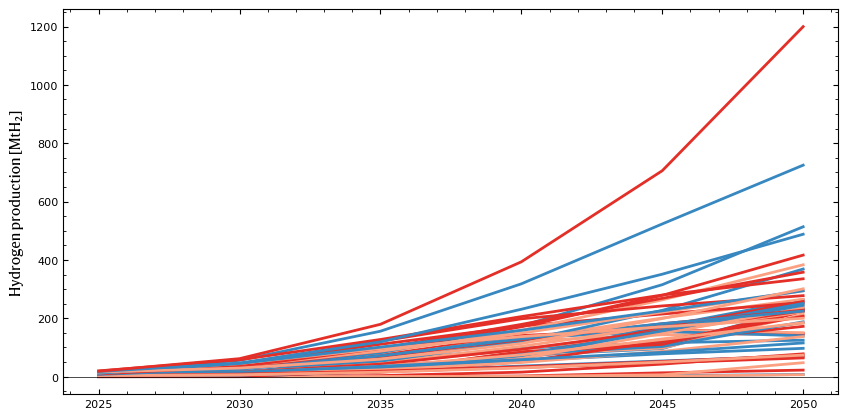

In [5]:
years=2025:5:2050
year_index=years.-2019 

fig, axs = plt.subplots(figsize=(10,5))#,figsize=(12,7)
axs.plot(years,ṁᴹᵗ[:,year_index]',linewidth=2)
axs.set_ylabel("Hydrogen production [MtH₂]",fontproperties=font_prop_labels)
axs.axhline(0, color="k", linewidth=0.5)
display(plt.gcf())
plt.close("all")


# **2. Estimating the allocation factor for hydrogen production**


## **2.1. Emission based allocation** 

In [6]:
Emi=getVals("Emissions|CO2|Gross",df=df);
Emiˢᵉ=getVals("Emissions|CO2|Gross|Energy|Supply");
αᵉᵐⁱ=Emiˢᵉ./Emi;


## **2.2. utilitarian principle** 

In [7]:
SE=getVals("Secondary Energy",df=df)
αˢᵉ=SEʰ²./SE;
α=αᵉᵐⁱ.*αˢᵉ
αᵏᵍ=α./ṁᵏᵍ;
αᴹᵗ=α./ṁᴹᵗ;
αᴳᵗ=α./ṁᴳᵗ;


remind scenarios

In [8]:
rmd_df=filter(s -> s[:Scenario] == "SSP1-PkBudg500" ||
                    s[:Scenario] == "SSP2EU-PkBudg500" ||
                    s[:Scenario] == "SSP5-PkBudg500"
                    , df);
                    
emiʰ²_rmd=getVals("Emissions|CO2|Gross|Energy|Supply|Hydrogen",df=rmd_df);
emiˢᵉ_rmd=getVals("Emissions|CO2|Gross|Energy|Supply",df=rmd_df);
emi_rmd=getVals("Emissions|CO2|Gross",df=rmd_df);
SE_rmd=getVals("Secondary Energy",df=rmd_df)
SEʰ²_rmd=getVals("Secondary Energy|Hydrogen",df=rmd_df)

ṁᵏᵍ_rmd=(SEʰ²_rmd.*EJH2_to_kgH2)# mass H2
ṁᴹᵗ_rmd=ṁᵏᵍ_rmd.*1e-9; # convert to Mt
ṁᴳᵗ_rmd=ṁᴹᵗ_rmd.*1e-3;  

β_rmd= (emiˢᵉ_rmd./emi_rmd).*(SEʰ²_rmd./SE_rmd)
βᵏᵍ_rmd= (emiˢᵉ_rmd./emi_rmd).*(SEʰ²_rmd./SE_rmd)./ṁᵏᵍ_rmd
βᴹᵗ_rmd= (emiˢᵉ_rmd./emi_rmd).*(SEʰ²_rmd./SE_rmd)./ṁᴹᵗ_rmd
γᵏᵍ_rmd= (emiʰ²_rmd./emi_rmd)./ṁᵏᵍ_rmd;


## **2.3. Economic allocation testing** 

In [9]:
lifetimes=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Lifetime"
                                "Tech|Hydrogen|Biomass|w/o CC|Lifetime"
                                "Tech|Hydrogen|Coal|w/ CC|Lifetime"
                                "Tech|Hydrogen|Coal|w/o CC|Lifetime"
                                "Tech|Hydrogen|Electricity|Lifetime"
                                "Tech|Hydrogen|Gas|w/ CC|Lifetime"
                                "Tech|Hydrogen|Gas|w/o CC|Lifetime"]] #yr

capex=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Biomass|w/o CC|Capital Costs"
                                "Tech|Hydrogen|Coal|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Coal|w/o CC|Capital Costs"
                                "Tech|Hydrogen|Electricity|Capital Costs"
                                "Tech|Hydrogen|Gas|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Gas|w/o CC|Capital Costs"]] #US$/kW

annual_capex=[i./j for (i,j) ∈ zip(capex,lifetimes)] #US$/kW/yr


capex_adj=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Biomass|w/o CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Coal|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Coal|w/o CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Electricity|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Gas|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Gas|w/o CC|Capital Costs|w/ Adj Costs"]]

annual_capex_adj=[i./j for (i,j) ∈ zip(capex_adj,lifetimes)] #US$/kW/yr

opex_fixed=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Biomass|w/o CC|OM Cost|fixed"
                                "Tech|Hydrogen|Coal|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Coal|w/o CC|OM Cost|fixed"
                                "Tech|Hydrogen|Electricity|OM Cost|fixed"
                                "Tech|Hydrogen|Gas|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Gas|w/o CC|OM Cost|fixed"]] #US$/kW/yr


opex_var=[getVals(i,df=rmd_df).*31.536 for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Biomass|w/o CC|OM Cost|variable"
                                        "Tech|Hydrogen|Coal|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Coal|w/o CC|OM Cost|variable"
                                        "Tech|Hydrogen|Electricity|OM Cost|variable"
                                        "Tech|Hydrogen|Gas|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Gas|w/o CC|OM Cost|variable"]] #US$/kW/yr
;

total_costs= [a.+b.+c for (a,b,c) ∈ zip(annual_capex,opex_fixed,opex_var)] #US$/kW/yr

total_costs=total_costs[1].+total_costs[2].+total_costs[3].+total_costs[4].+total_costs[5].+total_costs[6].+total_costs[7]


3×81 Matrix{Float64}:
 1367.43  1327.52  1287.62  1247.71  …  917.215  916.426  915.636  914.846
 1367.43  1326.49  1285.55  1244.61     922.453  922.38   922.307  922.235
 1367.43  1326.68  1285.92  1245.16     918.733  918.662  918.592  918.521

In [10]:
GDP=getVals("GDP|PPP",df=rmd_df)
αᵏᵍ_gdp= total_costs./GDP./ṁᵏᵍ_rmd


3×81 Matrix{Float64}:
 3.18451e-12  1.85058e-12  1.25652e-12  …  2.62995e-15  2.59704e-15
 3.18451e-12  1.76262e-12  1.17321e-12     1.06197e-15  1.03147e-15
 3.18451e-12  1.70824e-12  1.12291e-12     1.38931e-16  1.3577e-16

## **2.4 Comparison of allocation factors**

In this section, we use the results derived from the analysis in the [AR6.ipynb](AR6.ipynb) notebook. 

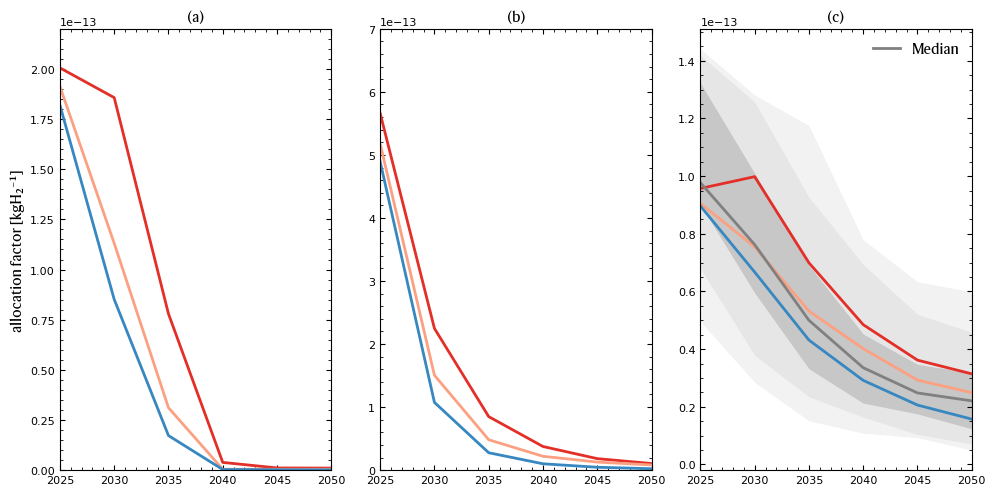

In [11]:
rcParams["axes.prop_cycle"] = plt.cycler("color",["#e32f27"
                                                "#fca082"
                                                "#3787c0"]);
years=2025:5:2050
year_index=years.-2019 

fig, axs = plt.subplots(1,3,figsize=(10,5))#,figsize=(12,7)
# ax.figure.set_facecolor("white")

## Remind emission based allocation
axs[1].set_title("(a)",fontproperties=font_prop_labels)
axs[1].plot(years,γᵏᵍ_rmd[:,year_index]',linewidth=2)
axs[1].set_ylabel("allocation factor [kgH₂⁻¹]",fontproperties=font_prop_labels)
axs[1].set_ylim(0, 2.2e-13)
axs[1].set_xlim(2025, 2050)


## Remind economic allocation
axs[2].set_title("(b)",fontproperties=font_prop_labels)
axs[2].plot(years,αᵏᵍ_gdp[:,year_index]',linewidth=2)
axs[2].set_ylim(0, 7e-13)
axs[2].set_xlim(2025, 2050)

# allocated space per kgH2 using utilitarian principle.
axs[3].set_title("(c)",fontproperties=font_prop_labels)
αᵏᵍmins = [minimum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αᵏᵍmaxs = [maximum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αq(a,q) = [quantile(filter(!isnan, a[:,j]), q ) for j in 1:size(a,2)][year_index]
αᵏᵍq05 , αᵏᵍq95 = αq(αᵏᵍ,0.05),αq(αᵏᵍ,0.95) #5-95th (90%) IQR 
αᵏᵍq25 , αᵏᵍq75 = αq(αᵏᵍ,0.25),αq(αᵏᵍ,0.75) #25-75th (50%) IQR
# αᵏᵍq40 , αᵏᵍq60 = αq(αᵏᵍ,0.40),αq(αᵏᵍ,0.60); #40-60th (20%) IQR
# αᵏᵍq10 = αq(αᵏᵍ,0.10); #40-60th (20%) IQR
αᵏᵍq50 = αq(αᵏᵍ,0.50)

# axs[3].plot(years,αᵏᵍ[:,year_index]',linewidth=2, color="grey",alpha=0.3)
axs[3].plot(years,βᵏᵍ_rmd[:,year_index]',linewidth=2)
axs[3].plot(years,αᵏᵍq50  ,label="Median",linewidth=2, color="grey")
axs[3].fill_between(x=years, y1=αᵏᵍmins, y2=αᵏᵍmaxs, color="grey",linewidth=0, alpha=0.1)
axs[3].fill_between(x=years, y1=αᵏᵍq05, y2=αᵏᵍq95, color="grey",linewidth=0, alpha=0.1) #85% proba
axs[3].fill_between(x=years, y1=αᵏᵍq25, y2=αᵏᵍq75, color="grey",linewidth=0, alpha=0.3) #70% proba
axs[3].set_xlim(2025, 2050)


plt.tight_layout()
plt.legend(frameon=false,prop=font_prop_labels)
plt.savefig(respath*"/SI_Fig3.svg",transparent=true)
plt.savefig(respath*"/SI_Fig3.png",dpi=800,transparent=true)
display(plt.gcf())
plt.close("all")


## Plotting utilitarian allocation factors

Next, we want to increase the interpolation to go from 5 years to 1 year step so cummulative emissions would render properly. We will simply use the `highres` function available in the supplementary variables. To avoid overcomplicating, we will just repeat what we did before with that function. 

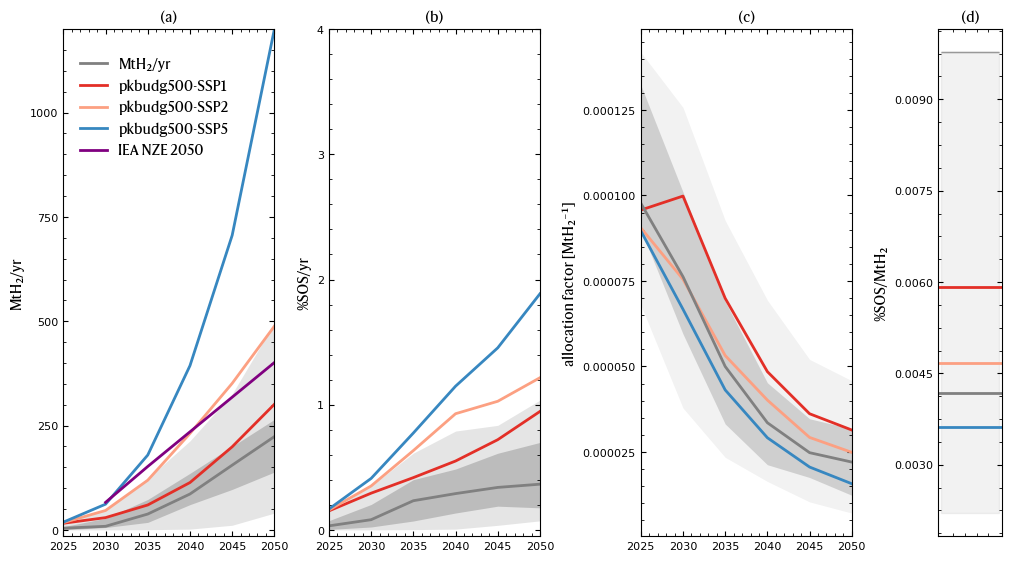

In [12]:
A,B,C,D = plt.figure(figsize=(10, 5.5),facecolor="none",layout="constrained").subplot_mosaic(
                                        "ABCD",
                                        width_ratios=[1,1,1,0.3])
                                        axs=[B,A,C,D]
                                        axs=[i[2] for i in axs]
years=2025:5:2050
year_index=years.-2019 
for (ax,mat,l) in  zip(axs[1:2],[ṁᴹᵗ,α.*100],["MtH₂/yr","%"])
    mins = (minimum(mat, dims=1)|>vec)[year_index]
    maxs = (maximum(mat, dims=1)|>vec)[year_index]
    q05 = (mapslices(x -> quantile(x, 0.05), mat; dims=1)|>vec)[year_index]
    q25 = (mapslices(x -> quantile(x, 0.25), mat; dims=1)|>vec)[year_index]
    q50 = (mapslices(x -> median(x), mat; dims=1)|>vec)[year_index]
    q75 = (mapslices(x -> quantile(x, 0.75), mat; dims=1)|>vec)[year_index]
    q95 = (mapslices(x -> quantile(x, 0.95), mat; dims=1)|>vec)[year_index]

    ax.plot(years, q50,color="grey",label=l,lw=2)
    # ax.fill_between(x=years, y1=mins, y2=maxs, color="grey",linewidth=0, alpha=0.1)
    ax.fill_between(x=years, y1=q05, y2=q95, color="grey",linewidth=0, alpha=0.2)
    ax.fill_between(x=years, y1=q25, y2=q75, color="grey",linewidth=0, alpha=0.4)
    ax.set_ylabel(l, fontproperties=font_prop)
    ax.tick_params(axis="both", direction="in")
end

for (i,k,l) in zip(1:3,["yellow","orange","purple"],["pkbudg500-SSP1","pkbudg500-SSP2","pkbudg500-SSP5"])
    axs[1].plot(years,ṁᴹᵗ_rmd[:,year_index][i,:]',linestyle="-",lw=2,label=l)
end

IEA_years=[2030, 2035, 2050]
IEA_vals=[66, 152, 401]#.*EJH2_to_kgH2*1.e-9
axs[1].plot(IEA_years,IEA_vals,label="IEA NZE 2050",color="purple",linestyle="-",lw=2)
axs[1].set_xlim(2025, 2050)
axs[1].set_ylabel("MtH₂/yr", fontproperties=font_prop)
axs[1].set_ylim(-15, 1200)
axs[1].set_title("(a)", fontproperties=font_prop)

# Total allocation factor
for (i,k) in zip(1:3,["yellow","orange","purple"])
    axs[2].plot(years,β_rmd[:,year_index][i,:].*100,linestyle="-",lw=2)
end
axs[2].set_xlim(2025, 2050)
axs[2].set_ylabel("%SOS/yr", fontproperties=font_prop)
axs[2].set_ylim(-0.0005.*100, 0.04.*100)
axs[2].set_title("(b)", fontproperties=font_prop)



# allocated space per kgH2 using utilitarian principle.
axs[3].set_title("(c)",fontproperties=font_prop_labels)
αᴹᵗmins = [minimum(filter(!isnan, αᴹᵗ[:,j])) for j in 1:size(αᴹᵗ,2)][year_index]
αᴹᵗmaxs = [maximum(filter(!isnan, αᴹᵗ[:,j])) for j in 1:size(αᴹᵗ,2)][year_index]
αq(a,q) = [quantile(filter(!isnan, a[:,j]), q ) for j in 1:size(a,2)][year_index]
αᴹᵗq05 , αᴹᵗq95 = αq(αᴹᵗ,0.05),αq(αᴹᵗ,0.95) #5-95th (90%) IQR 
αᴹᵗq25 , αᴹᵗq75 = αq(αᴹᵗ,0.25),αq(αᴹᵗ,0.75) #25-75th (50%) IQR
# αᵏᵍq40 , αᵏᵍq60 = αq(αᵏᵍ,0.40),αq(αᵏᵍ,0.60); #40-60th (20%) IQR
# αᵏᵍq10 = αq(αᵏᵍ,0.10); #40-60th (20%) IQR
αᴹᵗq50 = αq(αᴹᵗ,0.50)

axs[3].plot(years,βᴹᵗ_rmd[:,year_index]',linewidth=2)
axs[3].plot(years,αᴹᵗq50  ,label="Median",linewidth=2, color="grey")
# axs[3].fill_between(x=years, y1=αᴹᵗmins, y2=αᴹᵗmaxs, color="grey",linewidth=0, alpha=0.1)
axs[3].fill_between(x=years, y1=αᴹᵗq05, y2=αᴹᵗq95, color="grey",linewidth=0, alpha=0.1) #85% proba
axs[3].fill_between(x=years, y1=αᴹᵗq25, y2=αᴹᵗq75, color="grey",linewidth=0, alpha=0.3) #70% proba
axs[3].set_xlim(2025, 2050)
axs[3].set_ylabel("allocation factor [MtH₂⁻¹]",fontproperties=font_prop_labels)



vect=median(αᴹᵗ[:,year_index],dims=1)
minvect_hr=minimum(vect)*100
maxvect_hr=maximum(vect)*100
q50_hr=median(vect)*100
q05_hr = mapslices(x -> quantile(x, 0.05), vect; dims=1)*100
q25_hr = mapslices(x -> quantile(x, 0.25), vect; dims=1)*100
q75_hr = mapslices(x -> quantile(x, 0.75), vect; dims=1)*100
q95_hr= mapslices(x -> quantile(x, 0.95), vect; dims=1)*100
axs[4].axhline([q50_hr],color="grey",linestyle="-", xmin=0, xmax=1,lw=2)
axs[4].fill_between(x=[0, maxvect_hr], y1=minvect_hr, y2=maxvect_hr, color="grey", alpha=0.1)
axs[4].tick_params(bottom=false, labelbottom=false)
axs[4].fill_between(x=[0, maxvect_hr], y1=q05_hr[1], y2=q95_hr[1], color="grey", alpha=0.6)
axs[4].fill_between(x=[0, maxvect_hr], y1=q25_hr[1], y2=q75_hr[1], color="grey", alpha=0.4)
axs[4].set_ylabel("%SOS/MtH₂", fontproperties=font_prop)
axs[4].set_title("(d)", fontproperties=font_prop)
axs[4].tick_params(axis="both", top=false, bottom=false)

for (i,k) in zip(1:3,["#e32f27","#fca082","#3787c0"])
    vect=median(βᴹᵗ_rmd[:,year_index][i,:],dims=1)*100
    axs[4].axhline([vect],color=k,linestyle="-", xmin=0, xmax=1,lw=2)
end

axs[1].yaxis.set_major_locator(tkr.MaxNLocator(integer=true, nbins=5))
axs[2].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=5))
axs[3].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
axs[4].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, frameon=false, loc="upper center", bbox_to_anchor=(0.43, 0.97), ncol=1, prop=font_prop)
plt.savefig(respath*"summary_res.svg", bbox_inches="tight",transparent=true)
plt.savefig(respath*"summary_res.png", dpi=800,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


# **3. Allocated safe operating space**

First we load the safe operating space.

In [13]:
# sos=load("../Source data/02_results/2_01_global_space/data_SOS.jld2")
# @save respath*"allocation_factors.jld" SAP AP


Now we can unpack variables 

In [14]:
𝚫𝐗ᴾᵇ,𝚫𝐗ᴰ,units,catnames=sos["𝚫𝐗ᴾᵇ"],sos["𝚫𝐗ᴰ"],sos["units"],sos["control_var"];


UndefVarError: UndefVarError: `sos` not defined

$$
\boldsymbol{\omega^{b}} = \alpha \times \boldsymbol{\Delta X^{b}} \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$


When this is done, we need to broadcast these vectors into matrices to fit the dimensions of our study. We have 3 scenarios and 6 years. To respect the convention used in this work

$$
\boldsymbol{\Omega^{b}_{yq} = \alpha_{yq} \times \Delta X^{b}}  \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$

In [15]:
# 𝚨min =ones(3,6).*mins'
# 𝚨05=ones(3,6).*q_5'
# 𝚨25=ones(3,6).*q_25'
# 𝚨50=ones(3,6).*q_50'
# 𝚨75=ones(3,6).*q_75'
# 𝚨95=ones(3,6).*q_95'
# 𝚨max=ones(3,6).*maxs'


In [16]:
# 𝛀ᴾᵇ05=[𝚫𝐗ᴾᵇ*α for α in 𝚨05]'|>Matrix
# 𝛀ᴰ05=[𝚫𝐗ᴰ*α for α in 𝚨05]'|>Matrix

# 𝛀ᴾᵇ50=[𝚫𝐗ᴾᵇ*α for α in 𝚨50]'|>Matrix
# 𝛀ᴰ50=[𝚫𝐗ᴰ*α for α in 𝚨50]'|>Matrix

# 𝛀ᴾᵇ95=[𝚫𝐗ᴾᵇ*α for α in 𝚨95]'|>Matrix
# 𝛀ᴰ95=[𝚫𝐗ᴰ*α for α in 𝚨95]'|>Matrix


In [17]:
# @save respath*"aSOS.jld" 𝛀ᴾᵇ05 𝛀ᴾᵇ50 𝛀ᴾᵇ95 𝛀ᴰ05 𝛀ᴰ50 𝛀ᴰ95


# **4. Climate change scenario variables**

In [123]:
fair_ds = xr.open_dataset("/Users/mickael/Library/CloudStorage/OneDrive-UNSW/Research/Publications/Journal articles/1_Natcoms/Submission/Source data/01_input/FAIR/climate_data.nc")

GSTA_fair=fair_ds.GSTA.median(dim="config").sel(layer=0,scenario="ssp119",timebounds=(2015:1:2105).-1)
GSTA_fair_10yr_avg = GSTA_fair.rolling(timebounds=50, center=true).mean()
EFR_fair= fair_ds.ERF.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1)
EFR_CO2_fair= fair_ds.CO2_erf.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1)
atCO2_fair= fair_ds.atco2.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1);


In [ ]:
# GSTA_fair=fair_ds.GSTA.median(dim="config").sel(layer=0,scenario="ssp119")
# GSTA_fair_10yr_avg = GSTA_fair.sel(timebounds=(1850:1:1900)).rolling(timebounds=10, center=true).mean(dim="timebounds")
# mean(GSTA_fair_10yr_avg.values)
# mean(GSTA_fair_10yr_avg.values[6:1:47])


0.03899569293001064

In [124]:
GSTA=getVals("AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile",df=df)
RF=getVals("AR6 climate diagnostics|Effective Radiative Forcing|FaIRv1.6.2|50.0th Percentile",df=df);
GSTA_rmd=getVals("Temperature|Global Mean",df=rmd_df);

tucl=vcat(df[1:0, :],tucl_SSP2; cols = :union)
tucl_meta=tucl[:,1:4]
tucl_data=tucl[:,string.(2020:1:2100)]|>fill_missing!
tucl=hcat(tucl_meta,tucl_data);

img=vcat(df[1:0, :],img_SSP2; cols = :union)
img_meta=img[:,1:4]
img_data=img[:,string.(2020:1:2100)]|>fill_missing!
img=hcat(img_meta,img_data);
GSTA_tucl=getVals("Temperature|Global Mean",df=tucl)
GSTA_img=getVals("Temperature|Global Mean",df=img)

cumEmi_tucl=cumsum(getVals("Emissions|CO2",df=tucl),dims=2).*1e-6 # convert to GtCO2
img_world_emi=getVals("Emissions|CO2",df=img,matrix=false)[end,:]
cumEmi_img=cumsum(getVals("Emissions|CO2",df=DataFrame(img_world_emi)),dims=2).*1e-3;

Emi_tucl=getVals("Emissions|CO2",df=tucl).*1e6
Emi_img=getVals("Emissions|CO2",df=DataFrame(img_world_emi)).*1e9
Emi_rmd=getVals("Emissions|CO2",df=rmd_df).*1e9;


In [20]:
function IRF_CO2(year)
    alpha_0, alpha_1, alpha_2, alpha_3 = 0.2173, 0.2240, 0.2824, 0.2763
    tau_1, tau_2, tau_3 = 394.4, 36.54, 4.304
    exponentials(year, alpha, tau) = alpha * tau * (1 - exp(-year / tau))
    return (
        alpha_0 * year
        + exponentials(year, alpha_1, tau_1)
        + exponentials(year, alpha_2, tau_2)
        + exponentials(year, alpha_3, tau_3)
    )
end
function RF_CO2(impact,period)

    radiative_efficiency_ppb = 1.33e-5  # W/m2/ppb; 2019 background co2 concentration; IPCC AR6 Table 7.15
    
    # for conversion from ppb to kg-CO2
    M_co2 = 44.01  # g/mol
    M_air = 28.97  # g/mol, dry air
    m_atmosphere = 5.135e18  # kg [Trenberth and Smith, 2005]

    radiative_efficiency_kg = radiative_efficiency_ppb * (M_air / M_co2) * 1e9 / m_atmosphere  # W/m2/kg-CO2
    
    decay_multipliers = radiative_efficiency_kg * diff(IRF_CO2.(period)) #reduction of 1 year here 80
    years_period=length(period)-1
    
    decay_matrix=zeros(years_period,years_period)
    for i in 1:1:years_period
        decay_matrix[i,i:end]=decay_multipliers[1:end+1-i]
    end
    
    return  decay_matrix.*impact[1:end-1]

end
function Conc_CO2(impact,period)
    
    # for conversion from ppb to kg-CO2
    M_co2 = 44.01  # g/mol
    M_air = 28.97  # g/mol, dry air
    m_atmosphere = 5.135e18  # kg [Trenberth and Smith, 2005]

    concentration_per_kg =  (M_air / M_co2) * 1e9 / m_atmosphere  # W/m2/kg-CO2
    decay_multipliers = concentration_per_kg * diff(IRF_CO2.(period)) #reduction of 1 year here 80
    years_period=length(period)-1
    
    decay_matrix=zeros(years_period,years_period)
    for i in 1:1:years_period
        decay_matrix[i,i:end]=decay_multipliers[1:end+1-i]
    end
    
    return  decay_matrix.*impact[1:end-1].*1e-3#ppm

end


Conc_CO2 (generic function with 1 method)

In [21]:
Emi=getVals("Emissions|CO2",df=df).*1e9
years=2020:1:2100
period=years.-2019
decay_concentration=vcat([sum(Conc_CO2(Emi[ssp,period],period),dims=1).+409.9 for ssp in 1:size(Emi,1)]...)
decay_concentration_rmd=vcat([sum(Conc_CO2(Emi_rmd[ssp,period],period),dims=1).+409.9 for ssp in 1:3]...)
decay_concentration_tucl = sum(Conc_CO2(Emi_tucl,period),dims=1).+409.9
decay_concentration_img = sum(Conc_CO2(Emi_img,period),dims=1).+409.9

decayforcing=vcat([sum(RF_CO2(Emi[ssp,period],period),dims=1) for ssp in 1:size(Emi,1)]...).+2.16
decayforcing_rmd=vcat([sum(RF_CO2(Emi_rmd[ssp,period],period),dims=1) for ssp in 1:3]...).+2.16
decayforcing_tucl = sum(RF_CO2(Emi_tucl,period),dims=1).+2.16
decayforcing_img = sum(RF_CO2(Emi_img,period),dims=1).+2.16


1×80 Matrix{Float64}:
 2.22248  2.28017  2.33376  2.38377  …  2.00679  1.994  1.9813  1.96869

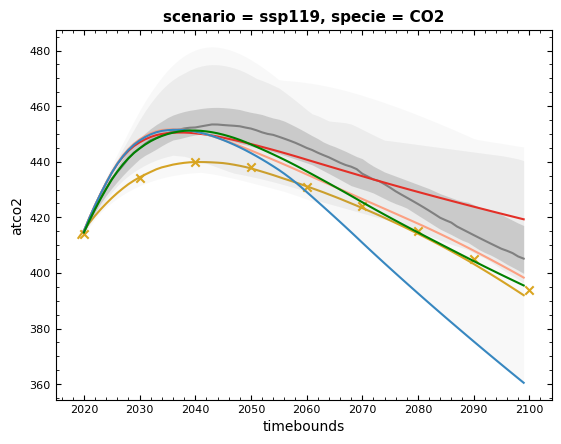

In [22]:
ssp19_years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
ssp19_ppm =   [414,  434,  440,  438,  431,  424,  415,  405,  394]
fig,ax=plt.subplots()

quant(a,q) = (mapslices(x -> quantile(x, q), a; dims=1)|>vec)

decay_concentration05=quant(decay_concentration,0.05)
decay_concentration25=quant(decay_concentration,0.25)
decay_concentration50=quant(decay_concentration,0.5)
decay_concentration75=quant(decay_concentration,0.75)
decay_concentration95=quant(decay_concentration,0.95)

ax.plot((2020:1:2099),decay_concentration50', color="grey")
ax.fill_between(x=(2020:1:2099), y1=decay_concentration05, y2=decay_concentration95, color="grey",alpha=0.1, linewidth=0)
ax.fill_between(x=(2020:1:2099), y1=decay_concentration25, y2=decay_concentration75, color="grey",alpha=0.3, linewidth=0)
ax.fill_between(x=(2020:1:2099), y1=(minimum(decay_concentration,dims=1)|>vec)', 
                                            y2=(maximum(decay_concentration,dims=1)|>vec)', 
                                            color="grey",alpha=0.05, linewidth=0)
ax.plot((2020:1:2099),decay_concentration_rmd' ,label="RMD")
# ax.plot((2020:1:2099),decay_concentration_tucl',label="Tucl")
ax.plot((2020:1:2099),decay_concentration_img' ,label="IMAGE", color="green")
ax.scatter(ssp19_years,ssp19_ppm,color="goldenrod",marker="x")
atCO2_fair.plot(ax=ax,x="timebounds", color="goldenrod", label="FaIRv1.6.2",zorder=0)
display(plt.gcf())
plt.close("all")


radiative forcing

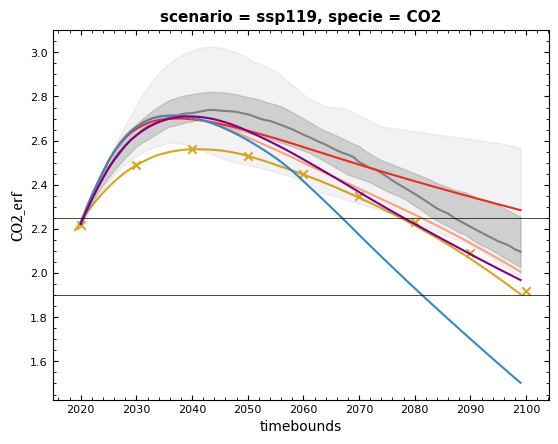

In [26]:
ssp19_years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
ssp19_erfCO2 =   [2.22,2.49,2.56,2.53,2.45,2.35,2.23,2.09,1.92]

quant(a,q) = (mapslices(x -> quantile(x, q), a; dims=1)|>vec)

decayforcing05=quant(decayforcing,0.05)
decayforcing25=quant(decayforcing,0.25)
decayforcing50=quant(decayforcing,0.5)
decayforcing75=quant(decayforcing,0.75)
decayforcing95=quant(decayforcing,0.95)

fig,ax=plt.subplots()
ax.plot((2020:1:2099),decayforcing50',color="grey")
ax.fill_between((2020:1:2099),decayforcing05,decayforcing95,color="grey",alpha=0.1)
ax.fill_between((2020:1:2099),decayforcing25,decayforcing75,color="grey",alpha=0.3)
ax.set_ylabel("ERF CO₂ [W/m²]", fontproperties=font_prop_labels)
ax.plot((2020:1:2099),decayforcing_rmd')
# ax.plot((2020:1:2099),decayforcing_tucl', color="green", label="Tucl")
ax.plot((2020:1:2099),decayforcing_img', color="purple", label="IMAGE")
ax.scatter(ssp19_years,ssp19_erfCO2,color="goldenrod",marker="x")
EFR_CO2_fair.plot(ax=ax,x="timebounds", color="goldenrod", label="FaIRv1.6.2",zorder=0)
ax.axhline(2.25, color="k", linewidth=0.5)
ax.axhline(1.9, color="k", linewidth=0.5)

display(plt.gcf())
plt.close("all")


main plot

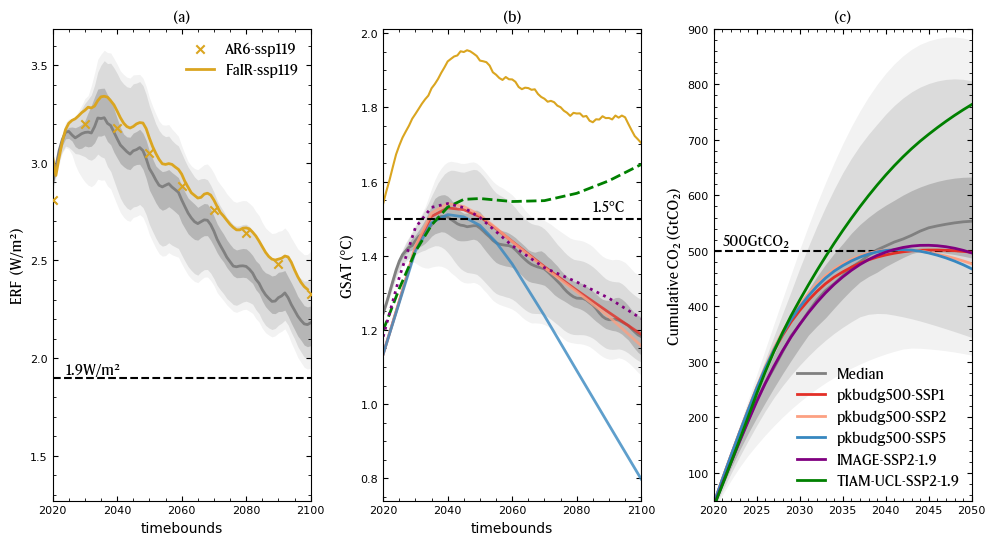

In [24]:
years=2020:1:2100
year_index=years.-2019

fig, axs = plt.subplots(1, 3,figsize=(10, 5.5))#1, 2, figsize=(10, 5.5)
# yrs_varmo=parse.(Int,names(getVals("Temperature|Global Mean")))
for (ax,mat,l) in  zip(axs,[RF,GSTA],[nothing,nothing])
    mins = minimum(mat, dims=1)|>vec
    maxs= maximum(mat, dims=1)|>vec
    q05 = mapslices(x -> quantile(x, 0.05), mat; dims=1)|>vec
    q25 = mapslices(x -> quantile(x, 0.25), mat; dims=1)|>vec
    q50 = mapslices(x -> median(x), mat; dims=1)|>vec
    q75 = mapslices(x -> quantile(x, 0.75), mat; dims=1)|>vec
    q95 = mapslices(x -> quantile(x, 0.95), mat; dims=1)|>vec
    
    ax.plot(years, q50[year_index],color="grey",label=l,lw=2)
    ax.fill_between(years, y1=mins[year_index], y2=maxs[year_index], color="grey",linewidth=0, alpha=0.1)
    ax.fill_between(years, y1=q05[year_index], y2=q95[year_index], color="grey",linewidth=0, alpha=0.2)
    ax.fill_between(years, y1=q25[year_index], y2=q75[year_index], color="grey",linewidth=0, alpha=0.4)
    ax.set_ylabel(l, fontproperties=font_prop)
    ax.tick_params(axis="both", direction="in")
end
## IPCC AR6 data 
ssp19_years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2200, 2300, 2400, 2500]
ssp19_erf = [2.81, 3.20, 3.18, 3.05, 2.88, 2.76, 2.64, 2.48, 2.33, 1.58, 1.49, 1.42, 1.38]
axs[1].scatter(ssp19_years, ssp19_erf,marker="x",color="goldenrod", label="AR6-ssp119",zorder=3)
EFR_fair.plot(x="timebounds", ax=axs[1],label="FaIR-ssp119", lw=2, color="goldenrod")

axs[2].plot(2020:1:2100, GSTA_rmd[:,(2020:1:2100).-2019]',label=["SSP1-pkbudg500","SSP2-pkbudg500", "SSP5-pkbudg500"],lw=2,linestyle="-",alpha=0.8)
axs[2].plot(2020:1:2100, GSTA_tucl[:,(2020:1:2100).-2019]',label="TIAM-UCL-SSP2-1.9",lw=2,linestyle="--",color="green")
axs[2].plot(2020:1:2100, GSTA_img[:,(2020:1:2100).-2019]',label="IMAGE-SSP2-1.9",lw=2,linestyle=":",color="purple")
GSTA_fair_10yr_avg.plot(x="timebounds", ax=axs[2],label="FaIR-SSP2-1.9", lw=1.5, color="goldenrod")

year2050=2020:1:2050
year_index2050=year2050.-2019
cumEmi=cumsum(getVals("Emissions|CO2",df=df),dims=2).*1e-3
cumEmi_rmd=cumsum(getVals("Emissions|CO2",df=rmd_df),dims=2).*1e-3
cumEmi_q50=(median(cumEmi, dims=1)|>vec)[year_index2050]
cumEmi_min=(minimum(cumEmi, dims=1)|>vec)[year_index2050]
cumEmi_max=(maximum(cumEmi, dims=1)|>vec)[year_index2050]
cumEmi_q05 = (mapslices(x -> quantile(x, 0.05), cumEmi; dims=1)|>vec)[year_index2050]
cumEmi_q25 = (mapslices(x -> quantile(x, 0.25), cumEmi; dims=1)|>vec)[year_index2050]
cumEmi_q75 = (mapslices(x -> quantile(x, 0.75), cumEmi; dims=1)|>vec)[year_index2050]
cumEmi_q95 = (mapslices(x -> quantile(x, 0.95), cumEmi; dims=1)|>vec)[year_index2050]

axs[3].plot(year2050, cumEmi_q50, color="grey", label="Median", lw=2)
axs[3].fill_between(x=year2050, y1=cumEmi_min, y2=cumEmi_max, color="grey", linewidth=0, alpha=0.1)
axs[3].fill_between(x=year2050, y1=cumEmi_q05, y2=cumEmi_q95, color="grey", linewidth=0, alpha=0.2) #90% proba
axs[3].fill_between(x=year2050, y1=cumEmi_q25, y2=cumEmi_q75, color="grey", linewidth=0, alpha=0.4) # 70% proba
axs[3].set_xlim(2020, 2050)
axs[3].set_ylim(50, 900)
axs[3].set_ylabel("Cumulative CO₂ (GtCO₂)", fontproperties=font_prop)
axs[3].annotate("500GtCO₂", xy=(2021, 510), xytext=(2021, 510), fontsize=10, fontproperties=font_prop)
axs[3].set_title("(c)", fontproperties=font_prop)   
axs[3].axhline([500],color="black",linestyle="--",xmax=1)
for (i,k,l) in zip(1:3,["yellow","orange","purple"],["pkbudg500-SSP1","pkbudg500-SSP2","pkbudg500-SSP5"])
    axs[3].plot(year2050,cumEmi_rmd[i,:][year_index2050],linestyle="-",label=l,lw=2)
end
axs[3].plot(year2050,cumEmi_img[year_index2050],label="IMAGE-SSP2-1.9",color="purple",linestyle="-",lw=2)
axs[3].plot(year2050,cumEmi_tucl[year_index2050],label="TIAM-UCL-SSP2-1.9",color="green",linestyle="-",lw=2)
axs[3].legend(frameon=false, prop=font_prop)


axs[1].axhline([1.9],color="black",linestyle="--",xmax=1)
axs[2].axhline([1.5],color="black",linestyle="--",xmax=1)
axs[1].annotate("1.9W/m²", xy=(2024, 1.92), xytext=(2024, 1.92), fontsize=10, fontproperties=font_prop)
axs[2].annotate("1.5°C", xy=(2085, 1.52), xytext=(2085, 1.52), fontsize=10, fontproperties=font_prop)

# axs[2].legend(frameon=false, loc= "lower left", prop=font_prop)
axs[1].legend(frameon=false, prop=font_prop)
axs[1].set_ylabel("ERF  (W/m²)", fontproperties=font_prop)
axs[2].set_ylabel("GSAT (°C)", fontproperties=font_prop)
axs[1].set_xlim(2020, 2100)
axs[2].set_xlim(2020, 2100)
axs[1].set_title("(a)", fontproperties=font_prop)
axs[2].set_title("(b)", fontproperties=font_prop)

fig.tight_layout()

display(plt.gcf())
fig.savefig(respath*"climate_vars.svg", bbox_inches="tight",transparent=true)
fig.savefig(respath*"climate_vars.png", dpi=800 ,bbox_inches="tight",transparent=true)
plt.close("all")


# Climate change variables

In [71]:
## Data from the Annex III of the Intergovernmental Panel On Climate Change (Ipcc) (2023) Climate Change 2021 – The Physical Science Basis: Working Group I Contribution to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change. 1st edn. Cambridge University Press. Available at: https://doi.org/10.1017/9781009157896.


hist_years_erf =[1750, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2015, 2019]
hist_years_ppm = [
    1750, 1850, 1860, 1870, 1880, 1890, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935,
    1940, 1945, 1950, 1955, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
    1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
    2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019
]
ssp19_years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2200, 2300, 2400, 2500]

hist_ppm = [
    278.3, 285.5, 286.8, 288.4, 290.4, 293.3, 296.4, 298.0, 300.0, 302.5, 304.8, 306.3, 307.1, 308.6,
    311.7, 312.7, 313.1, 314.6, 316.8, 317.5, 318.2, 318.8, 319.5, 320.0, 321.0, 321.6,
    358.2, 360.0, 361.8, 362.5, 365.5, 367.6, 368.8, 370.4, 372.4, 375.0, 376.8, 378.8,
    381.0, 382.7, 384.8, 386.3, 388.6, 390.5, 392.5, 395.2, 397.1, 399.4, 402.9, 405.0, 407.4, 409.9
]
ssp19_ppm =   [414,  434,  440,  438,  431,  424,  415,  405,  394,  343,  342,  339,  337]
ssp126_ppm = [414, 440, 458, 469, 474, 473, 467, 457, 446, 403, 396, 389, 384]

hist_erf = [0.3, 0.33, 0.34 ,.3, 0.43, 0.48, 0.52, 0.59, 0.54, 0.42, 0.86, 1.42, 2.02, 2.23, 2.61, 2.84]
ssp19_erf = [2.81, 3.20, 3.18, 3.05, 2.88, 2.76, 2.64, 2.48, 2.33, 1.58, 1.49, 1.42, 1.38]
ssp26_erf = [2.80, 3.21, 3.48, 3.58, 3.58, 3.54, 3.42, 3.25, 3.10, 2.50, 2.30, 2.19, 2.11];


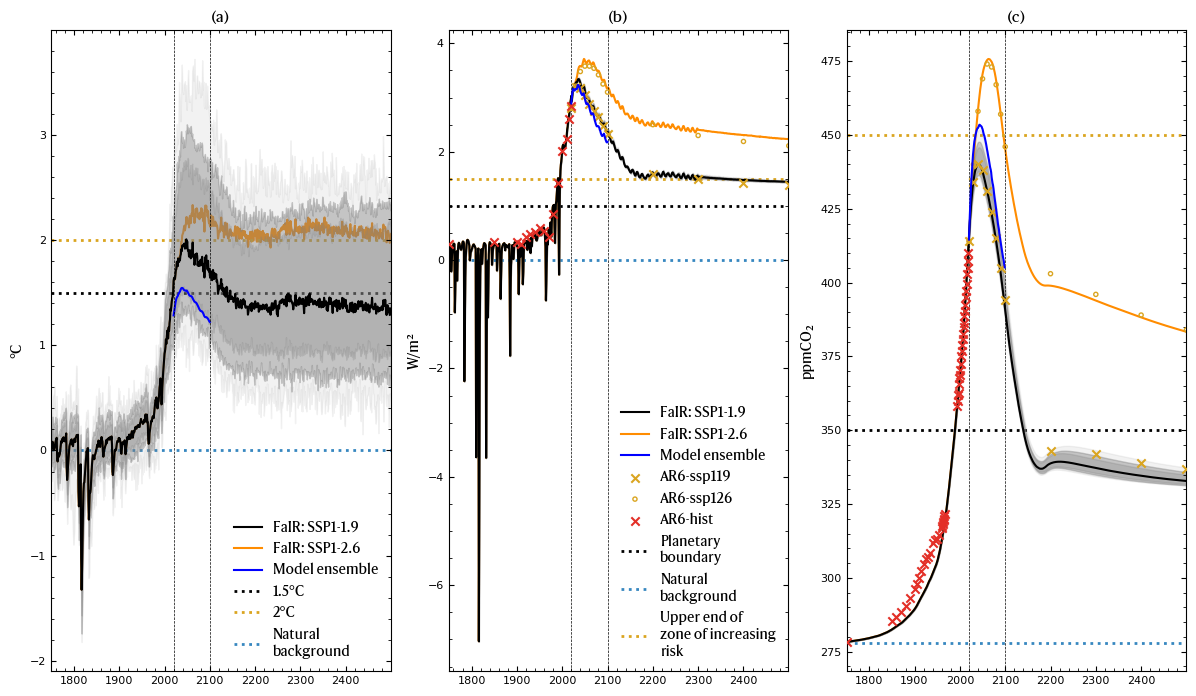

In [125]:
fig, axs = plt.subplots(1,3, figsize=(12,7))
period=fair_ds.timebounds

############ Global Surface Air Temperature Anomaly (GSTA) ############
TA=fair_ds.GSTA.sel(scenario="ssp119",layer=0)
TA26=fair_ds.GSTA.sel(scenario="ssp126",layer=0)
TAq05=TA.quantile(0.05, dim="config")
TAq16=TA.quantile(0.16, dim="config")
TAq84=TA.quantile(0.84, dim="config")
TAq95=TA.quantile(0.95, dim="config")
TAq50=TA.median(axis=1)
TAq50ssp126=TA26.median(axis=1)
TAmin=TA.min(dim="config")
TAmax=TA.max(dim="config")

TAq50.plot(ax=axs[1], label="FaIR: SSP1-1.9", color="k")
TAq50ssp126.plot(ax=axs[1], label="FaIR: SSP1-2.6", color="darkorange",zorder=0)
#GSTA background in IPCC AR6,rolling average of 10 years for the 1850-1900 period
backg=0.03899569293001064

axs[1].plot((2020:1:2100),median(GSTA.+backg,dims=1)',color="blue",label="Model ensemble")
axs[1].fill_between(period, TAmin, TAmax, alpha=0.1, color="grey")
axs[1].fill_between(period, TAq05, TAq95, alpha=0.4, color="grey")
axs[1].fill_between(period, TAq16, TAq84, alpha=0.25, color="grey")
axs[1].set_xlim(period[1], period[-1])
axs[1].set_xlabel("")
axs[1].set_title("(a)",fontproperties=font_prop_titles)
axs[1].set_ylabel("°C",fontproperties=font_prop_labels)
axs[1].axhline(1.5, ls=":",label="1.5°C", color="k",linewidth=2,zorder=0)
axs[1].axhline(2, ls=":",label="2°C", color="goldenrod",linewidth=2,zorder=0)
axs[1].axhline(0, ls=":",label="Natural\nbackground", color="#3787c0",linewidth=2,zorder=0)
axs[1].legend(frameon=false,prop=font_prop_labels)
axs[1].axvline(2100, ls="--", color="k", linewidth=0.5)
axs[1].axvline(2020, ls="--", color="k", linewidth=0.5)


############ Effective Radiative Forcing (ERF) ############
ERF=fair_ds.ERF.sel(scenario="ssp119")
ERF26=fair_ds.ERF.sel(scenario="ssp126")
ERFq05=ERF.quantile(0.05, dim="config")
ERFq16=ERF.quantile(0.16, dim="config")
ERFq84=ERF.quantile(0.84, dim="config")
ERFq95=ERF.quantile(0.95, dim="config")
ERFq50=ERF.median(axis=1)
ERFq50ssp126=ERF26.median(axis=1)
ERFmin=ERF.min(dim="config")
ERFmax=ERF.max(dim="config")

ERFq50.plot(ax=axs[2], label="FaIR: SSP1-1.9", color="k")
ERFq50ssp126.plot(ax=axs[2], label="FaIR: SSP1-2.6", color="darkorange",zorder=0)
#RF
axs[2].plot((2020:1:2100),median(RF,dims=1)',color="blue",label="Model ensemble",zorder=5)
axs[2].fill_between(period, ERFmin, ERFmax, alpha=0.1, color="grey")
axs[2].fill_between(period, ERFq05, ERFq95, alpha=0.4, color="grey")
axs[2].fill_between(period, ERFq16, ERFq84, alpha=0.25, color="grey")
axs[2].scatter(ssp19_years, ssp19_erf,marker="x",color="goldenrod", label="AR6-ssp119",zorder=3)
axs[2].scatter(ssp19_years, ssp26_erf,marker=".",edgecolor="goldenrod",color="none", label="AR6-ssp126",zorder=3)
axs[2].scatter(hist_years_erf, hist_erf,marker="x",color="#e32f27", label="AR6-hist",zorder=3)
# axs[1].fill_between(period, 0,1, alpha=0.1,color="lime",edgecolor='none',zorder=0)
# axs[1].fill_between(period, 1,1.5, alpha=0.105,color="darkorange",edgecolor='none',zorder=0)
axs[2].axhline(1, ls=":",label="Planetary\nboundary", color="k",linewidth=2,zorder=0)
axs[2].axhline(0, ls=":",label="Natural\nbackground", color="#3787c0",linewidth=2,zorder=0)
axs[2].axhline(1.5, ls=":",label="Upper end of\nzone of increasing\nrisk", color="goldenrod",linewidth=2,zorder=0)
axs[2].set_ylabel("W/m²",fontproperties=font_prop_labels)
axs[2].set_xlabel("")
axs[2].set_xlim(period[1], period[-1])
axs[2].set_title("(b)",fontproperties=font_prop_titles)
# axs[2].legend(frameon=false,prop=font_prop_labels)

# ############ Effective Radiative Forcing CO2 (ERF) ############
# ssp19_yearsCO2 = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
# ssp19_erfCO2 =   [2.22,2.49,2.56,2.53,2.45,2.35,2.23,2.09,1.92]
# ssp26_erfCO2 =   [2.22,1.56,2.79,2.93,2.99,2.98,2.91,2.78,2.63]

# ERF=fair_ds.CO2_erf.sel(scenario="ssp119")
# ERF26=fair_ds.CO2_erf.sel(scenario="ssp126")
# ERFq05=ERF.quantile(0.05, dim="config")
# ERFq16=ERF.quantile(0.16, dim="config")
# ERFq84=ERF.quantile(0.84, dim="config")
# ERFq95=ERF.quantile(0.95, dim="config")
# ERFq50=ERF.median(axis=1)
# ERFq50ssp126=ERF26.median(axis=1)
# ERFmin=ERF.min(dim="config")
# ERFmax=ERF.max(dim="config")

# ERFq50.plot(ax=axs[2], label="ssp119 median", color="k")
# ERFq50ssp126.plot(ax=axs[2], label="ssp126 median", color="darkorange",zorder=0)
# axs[2].fill_between(period, ERFmin, ERFmax, alpha=0.1, color="grey")
# axs[2].fill_between(period, ERFq05, ERFq95, alpha=0.4, color="grey")
# axs[2].fill_between(period, ERFq16, ERFq84, alpha=0.25, color="grey")
# axs[2].scatter(ssp19_yearsCO2, ssp19_erfCO2,marker="x",color="goldenrod", label="AR6-ssp119",zorder=3)
# axs[2].scatter(ssp19_yearsCO2, ssp26_erfCO2,marker=".",edgecolor="goldenrod",color="none", label="AR6-ssp126",zorder=3)
# # axs[2].scatter(hist_years_erf, hist_erf,marker="x",color="#e32f27", label="AR6-hist",zorder=3)
axs[2].legend(frameon=false,prop=font_prop_labels)
axs[2].axvline(2100, ls="--", color="k", linewidth=0.5)
axs[2].axvline(2020, ls="--", color="k", linewidth=0.5)

############ Atmospheric CO2 concentration ############
CO2_conc=fair_ds.atco2.sel(scenario="ssp119")
CO2_conc26=fair_ds.atco2.sel(scenario="ssp126")
CO2_concq05=CO2_conc.quantile(0.05, dim="config")
CO2_concq16=CO2_conc.quantile(0.16, dim="config")
CO2_concq84=CO2_conc.quantile(0.84, dim="config")
CO2_concq95=CO2_conc.quantile(0.95, dim="config")
CO2_concq50=CO2_conc.median(axis=1)
CO2_concq50ssp126=CO2_conc26.median(axis=1)
CO2_concmin=CO2_conc.min(dim="config")
CO2_concmax=CO2_conc.max(dim="config")

CO2_concq50.plot(ax=axs[3], label="FaIR: SSP1-19", color="k")
CO2_concq50ssp126.plot(ax=axs[3], label="FaIR: SSP1-26", color="darkorange",zorder=0)
axs[3].plot((2020:1:2099),decay_concentration50', color="blue",zorder=5)

axs[3].set_title("(c)",fontproperties=font_prop_titles)
axs[3].fill_between(period, CO2_concmin, CO2_concmax, alpha=0.1, color="grey")
axs[3].fill_between(period, CO2_concq05, CO2_concq95, alpha=0.4, color="grey")
axs[3].fill_between(period, CO2_concq16, CO2_concq84, alpha=0.25, color="grey")
axs[3].scatter(ssp19_years, ssp19_ppm,marker="x",color="goldenrod", label="AR6-ssp119",zorder=3)
axs[3].scatter(ssp19_years, ssp126_ppm,marker=".",edgecolor="goldenrod",color="none", label="AR6-ssp126",zorder=3)
axs[3].scatter(hist_years_ppm, hist_ppm,marker="x",color="#e32f27", label="AR6-hist",zorder=3)
axs[3].axhline(350, ls=":",label="Planetary\nboundary", color="k",linewidth=2,zorder=0)
axs[3].axhline(278, ls=":",label="Natural\nbackground", color="#3787c0",linewidth=2,zorder=0)
axs[3].axhline(450, ls=":",label="Upper end of\nzone of increasing\nrisk", color="goldenrod",linewidth=2,zorder=0)

axs[3].set_xlim(period[1], period[-1])
axs[3].set_ylabel("ppmCO₂",fontproperties=font_prop_labels)
axs[3].set_xlabel("")

axs[3].axvline(2100, ls="--", color="k", linewidth=0.5)
axs[3].axvline(2020, ls="--", color="k", linewidth=0.5)
############ Formatting ############
plt.tight_layout()
fig.savefig(respath*"climate_vars.svg", bbox_inches="tight",transparent=true)
fig.savefig(respath*"climate_vars.png", dpi=800 ,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")
